In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio.compliance import kaldi
from torchaudio.functional import resample

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

from time import time

import timm

import wandb

In [3]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

In [4]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "BirdAudioMAE_Baseline"
    backbone_name = "hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"
    n_classes = 728 # number of classes in the dataset
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    batch_size = 8
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 5
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(config.random_seed)

In [5]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

#save the label_to_id mapping
label_to_id_df = pd.DataFrame(label_to_id.items(), columns=['scientific_name', 'species_id'])
label_to_id_df.to_csv(f"{config.log_dir}/{config.model_name}_label_map.csv", index=False)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329


In [6]:
# check if all species in greater_manaus are in amazonas
greater_manaus = df_audio_meta[df_audio_meta['region'] == 'greater_manaus']
amazonas = df_audio_meta[df_audio_meta['region'] == 'amazonas']

print('Number of species in greater_manaus:', len(greater_manaus['scientific_name'].unique()))
print('Number of species in amazonas:', len(amazonas['scientific_name'].unique()))

shared_species = [x for x in greater_manaus['scientific_name'].unique().tolist() if x in amazonas['scientific_name'].unique().tolist()]

print('Number of species in both regions:', len(shared_species))

Number of species in greater_manaus: 197
Number of species in amazonas: 724
Number of species in both regions: 193


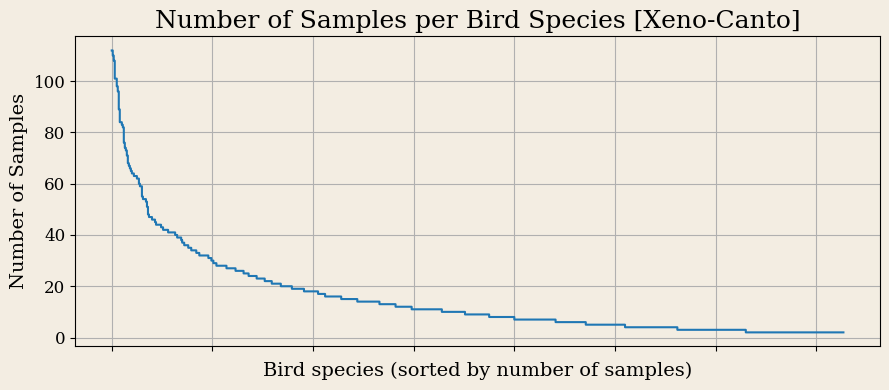

In [7]:
# calculate the number of samples per class and weights for focal loss
class_counts = df_audio_meta['species_id'].value_counts().sort_index()
class_weights = 1 / class_counts

# plot the distribution of the number of samples per class
fig, ax = plt.subplots(figsize=(9, 4))

class_counts_sorted = class_counts.sort_values(ascending=False)
ax.step(np.arange(class_counts_sorted.shape[0]), class_counts_sorted.values)
ax.set_xticks(np.arange(0, class_counts_sorted.shape[0], 100), None) # class_counts_sorted.index[::10], rotation=90)
ax.set_xticklabels([])
# ax = plt.gca()
# ax_right = ax.twinx()
# ax_right.plot(np.arange(class_counts_sorted.shape[0]), class_weights[class_counts_sorted.index].values, color='red')

ax.tick_params(axis='y', labelcolor='black', labelsize=12, labelfontfamily='serif')
ax.set_xlabel('Bird species (sorted by number of samples)', fontsize=14, fontfamily='serif')
ax.set_ylabel('Number of Samples', fontsize=14, fontfamily='serif')
ax.set_title('Number of Samples per Bird Species [Xeno-Canto]', fontsize=18, fontfamily='serif')
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
class BirdAudioMAEDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.config = config
        self.global_mean = -4.2677393
        self.global_std = 4.5689974
    
    def __len__(self):
        return len(self.df_audio_meta)
    
    def preprocess(self, x: torch.Tensor):
        x = x - x.mean()
        melspec = kaldi.fbank(x.unsqueeze(0), htk_compat=True, window_type="hanning", num_mel_bins=128)
        if melspec.shape[0] < 1024:
            melspec = F.pad(melspec, (0, 0, 0, 1024 - melspec.shape[0]))
        else:
            melspec = melspec[:1024]
        melspec = (melspec - self.global_mean) / (self.global_std * 2)
        return melspec

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
         # load audio file
        audio_arr, sr = librosa.load(audio_path, sr=self.config.audio_sr) 
        # get the spectrogram
        spec = self.preprocess(torch.tensor(audio_arr))
        return spec, row['species_id']

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [9]:
# test the dataset
dataset = BirdAudioMAEDataset(df_audio_meta, config)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=config.num_workers)

for data in dataloader:
    print(data['input_ids'].shape, data['labels'].shape)
    break

torch.Size([2, 1024, 128]) torch.Size([2])


In [10]:
class BirdAudioMAE(nn.Module):
    
    def __init__(self, backbone_name, n_classes, n_mlp_layers=1, activation='silu'):
        super(BirdAudioMAE, self).__init__()
        
        # pre-trained backbone
        self.feature_encoder = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        self.hidden_size = self.feature_encoder.embed_dim
        
        # self.feature_encoder = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu', 'silu' or 'gelu'.")
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_frames, n_mels)
        # output: (batch_size, n_classes)
        
        encoder_output = self.feature_encoder(spectrogram.unsqueeze(1))
        logits = self.mlp(encoder_output)
        
        return {'logits': logits}


In [11]:
# test the model / loss_fn / eval_fn using dataloader

bs_dataset = BirdAudioMAEDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(config.backbone_name)

bird_audio_mae_model = BirdAudioMAE(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')

for batch in bs_dataloader:
    
    input_ids = batch['input_ids']
    labels = batch['labels']
    
    output = bird_audio_mae_model(input_ids)
    logits = output['logits']
    
    print(f"Shape of input_ids: {input_ids.shape}")
    print(f"Shape of labels: {labels.shape}")
    print(f"Shape of logits: {logits.shape}")
    # print(f"Loss: {loss.item()}, Eval Score: {eval_score}")
    
    break

hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k
Shape of input_ids: torch.Size([8, 1024, 128])
Shape of labels: torch.Size([8])
Shape of logits: torch.Size([8, 728])


In [12]:
# define loss_fn and eval_fn
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=0, alpha=None, reduction='mean', device=DEVICE):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        if isinstance(alpha, (float, int, )): 
            self.alpha = torch.Tensor([alpha, 1-alpha])
        elif isinstance(alpha, (list, np.ndarray)): 
            self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        else:
            raise TypeError('Invalid alpha type')
        
        self.ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets) # nn.CrossEntropyLoss already applies log_softmax
        pt = torch.exp(-ce_loss) # CE = -log(p_t) -> p_t = exp(-CE)
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return_method = {
            'mean': torch.mean,
            'sum': torch.sum,
            'none': lambda x: x
        }
        
        return return_method[self.reduction](focal_loss)
        
        
# eval_fn
class ROC_AUC_Score(nn.Module):
    
    def __init__(self, config, average='macro', multi_class='ovo'):
        super(ROC_AUC_Score, self).__init__()
        self.num_classes = config.n_classes
        self.average = average
        self.multi_class = multi_class  # 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
        self.label_ids = np.arange(self.num_classes)

    def forward(self, logits, targets):
        # logits: (batch_size, n_classes)
        # targets: (batch_size,) with integer labels
        
        # Apply softmax to convert logits to probabilities
        probas = torch.exp(F.log_softmax(logits, dim=1))

        # Detach and move to CPU for sklearn compatibility
        probas = probas.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        df_scores = pd.DataFrame(probas, columns=self.label_ids)
        df_scores['target'] = targets
        
        # remove samples with classes which is predeicted as 0 in all samples
        unscored_cols = df_scores.columns[df_scores.sum(axis=0) == 0]
        rows_to_remove = df_scores['target'].isin(unscored_cols)
        df_scores = df_scores[~rows_to_remove]
        
        eval_score = roc_auc_score(
            y_true=df_scores['target'].values,
            y_score=df_scores[self.label_ids].values,
            average=self.average, 
            multi_class=self.multi_class,
            labels=self.label_ids
        )
        
        return eval_score

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, logger, config, is_higher_better=True):
        '''
        model: nn.Module
        loss_fn: loss function
        evel_fn: evaluation function
        logger: logger
        config: Config
        is_higher_better: bool (default: True) whether higher evaluation score is better
        '''

        self.model = model
        self.logger = logger
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        self.is_higher_better = is_higher_better
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.weight_decay)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.epochs)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.epochs - 1)):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if self.is_higher_better:
                if valid_loss > best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
            else:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.amp)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(self.device)
            labels = data_dict['labels'].to(self.device)
            
            if is_train:
                with autocast(enabled=self.config.amp):
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.grad_accum_steps > 1:
                    train_loss = train_loss / self.config.grad_accum_steps
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                if (step + 1) % self.config.grad_accum_steps == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    valid_loss = self.loss_fn(logits, labels)

                if self.config.grad_accum_steps > 1:
                    valid_loss = valid_loss / self.config.grad_accum_steps
                    
                loss_meter.update(valid_loss.item())
                
                predicts_record.append(logits)
                labels_record.append(labels)
            
            end = time()
            
            if self.config.print_freq:
                if (step % self.config.print_freq == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {loss_meter.avg:.4f}"

                    info += f" | Elapse: {end - start:.2f}s"
                    self.logger.info(info)

        if is_train:
            wandb.log({
                "Train Loss": loss_meter.avg, 
                "Learning Rate": self.scheduler.get_last_lr()[0],
                "Gradient Norm": grad_norm,
                "Epoch": epoch_id + 1
            })
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                torch.cat(predicts_record).cpu(),
                torch.cat(labels_record).cpu()
                )
            wandb.log({
                "Valid Loss": loss_meter.avg,
                "Eval Score": eval_loss,
                "Epoch": epoch_id + 1
            })
            predicts_record = np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


In [14]:
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [15]:
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=False)
df_audio_meta['fold'] = 0

for fold, (train_index, valid_index) in enumerate(skf.split(df_audio_meta, df_audio_meta['species_id'])):
    df_audio_meta.loc[valid_index, 'fold'] = fold

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [16]:
loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

oof, loss_history = pd.DataFrame(), []

logger = get_logger(log_file=f"{config.log_dir}/{config.model_name}_training.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in config.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

################################### TRAIN_CONFIG ###################################
dataset_dir: ./Audio_XenoCanto
labels_list: ./xeno_labels.csv
model_name: BirdAudioMAE_Baseline
backbone_name: hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k
n_classes: 728
audio_sr: 16000
segment_length: 10
fft_window: 0.025
hop_window_length: 0.01
n_mels: 128
low_cut: 1000
high_cut: 8000
top_db: 100
batch_size: 8
num_workers: 0
n_splits: 5
log_dir: ./training_logs
max_lr: 1e-05
epochs: 5
weight_decay: 0.01
lr_final_div: 1000
amp: True
grad_accum_steps: 1
max_grad_norm: 10000000.0
print_epoch_freq: 1
print_freq: 200
random_seed: 2046
copy: <classmethod(<function Config.copy at 0x7f1294e09800>)>
################################################################################


In [17]:
# --------------------------------------------------------------
# Training Loop Starts Here
# --------------------------------------------------------------
    
loader_kwargs = {
    "batch_size": config.batch_size,
    "num_workers": config.num_workers,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]
    
for fold_id in range(config.n_splits):
    tik = time()
    
    wandb_init(project_name=config.model_name, run_name=f"fold_{fold_id}", config=config)
    
    train_df = df_audio_meta[df_audio_meta['fold'] != fold_id].copy().reset_index(drop=True)
    valid_df = df_audio_meta[df_audio_meta['fold'] == fold_id].copy().reset_index(drop=True)
    
    train_folds = BirdAudioMAEDataset(train_df, config)
    valid_folds = BirdAudioMAEDataset(valid_df, config)
    
    train_loader = DataLoader(train_folds, **loader_kwargs)
    valid_loader = DataLoader(valid_folds, **loader_kwargs)
    
    # Initialize the model
    model = BirdAudioMAE(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')
    
    # Initialize the trainer
    trainer = Trainer(model, loss_fn, eval_fn, logger, config, is_higher_better=True)
    
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, 
        valid_loader, 
        print_epoch_freq=config.print_epoch_freq,
        from_checkpoint=None,
        use_tqdm=True
        )
    
    loss_history.append(loss_records)
    
    # Save oof predictions
    df_valid = pd.DataFrame({'species_id': valid_df['species_id'], 'fold': fold})
    df_valid[prediction_columns] = best_preds
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    save_model_name = f"{config.model_name}_fold_{fold_id}"
    torch.save(best_weights, f"{config.log_dir}/{save_model_name}.pth")

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    valid_loss_fold = eval_fn(
        torch.tensor(oof[prediction_columns].values),
        torch.tensor(oof['species_id'].values)
    )
    logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
        
# Summarize the final results
valid_loss = eval_fn(
    torch.tensor(oof[prediction_columns].values),
    torch.tensor(oof['species_id'].values)
)

# plot the loss history
plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(config.log_dir, f"{config.model_name}_loss.jpg"))

# Save the OOF predictions
oof.to_csv(f"{config.log_dir}/{config.model_name}_oof.csv", index=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 1 [0/1117] | Train Loss: 0.3995 Grad: 90400.9297 LR: 4.0008e-07 | Elapse: 0.92s
Epoch 1 [200/1117] | Train Loss: 0.2296 Grad: 10885.3916 LR: 3.1636e-06 | Elapse: 23.19s
Epoch 1 [400/1117] | Train Loss: 0.2182 Grad: 113325.3906 LR: 8.2513e-06 | Elapse: 45.58s
Epoch 1 [600/1117] | Train Loss: 0.1988 Grad: 97.7399 LR: 9.9982e-06 | Elapse: 68.07s
Epoch 1 [800/1117] | Train Loss: 0.1828 Grad: 5777.2119 LR: 9.9422e-06 | Elapse: 90.72s
